# 전이학습
- 분류기에 해당하는 FC 레이어를 재학습하거나, 출력 레이어만 재학습한다
 - 이 때 앞 단의 파라미터들을 고정(freeze)할 수도 있고, 재학습시킬 수도 있다
- 학습시킬 데이터가 적을 때 유용하다. 미리 대용량 데이터로 학습시킨 모델을 활용하는 것이 전이학습의 목적이다
 - ResNet18을 이용하는 예제
 - 개미와 벌 이미지 구분에 적용

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [3]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.10.0+cu111  Device: cuda


In [4]:
BATCH_SIZE = 32
EPOCHS = 10

## 개미와 벌 이미지 데이터 다운로드


In [5]:
!curl -L https://download.pytorch.org/tutorial/hymenoptera_data.zip -o ants.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 45.0M  100 45.0M    0     0  53.8M      0 --:--:-- --:--:-- --:--:-- 53.8M


In [6]:
!unzip ants.zip

Archive:  ants.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg  
  inflating: hymenoptera_data/train/ants/1473187633_63ccaac

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), # 랜덤 위치의 크로핑
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

image_datasets = {x: datasets.ImageFolder("/content/hymenoptera_data", data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = BATCH_SIZE, num_workers = 0, shuffle = True) for x in ['train', 'val']}

In [8]:
# 데이터 확인하기
for (X_train, y_train) in dataloaders['train']:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 224, 224]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

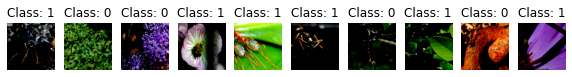

In [9]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

In [11]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [13]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

# 모델만 사용하기 (사전학습된 파라미터를 사용하지 않는 경우)
- 성능이 67% 정도 나온다

In [14]:
# 미리 학습되지 않은 ResNet18 모델 불러온 후 Output 크기 설정
import torchvision.models as models
model = models.resnet18(pretrained = False).cuda()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.cuda()

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
criterion = nn.CrossEntropyLoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, log_interval = 5)
    test_loss, test_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/397 (0%)]	Train Loss: 0.667443
Train Epoch: 1 [160/397 (38%)]	Train Loss: 0.762711
Train Epoch: 1 [320/397 (77%)]	Train Loss: 0.703697

[EPOCH: 1], 	Test Loss: 0.7121, 	Test Accuracy: 56.42 % 

Train Epoch: 2 [0/397 (0%)]	Train Loss: 0.650672
Train Epoch: 2 [160/397 (38%)]	Train Loss: 0.670032
Train Epoch: 2 [320/397 (77%)]	Train Loss: 0.763002

[EPOCH: 2], 	Test Loss: 0.7185, 	Test Accuracy: 60.20 % 

Train Epoch: 3 [0/397 (0%)]	Train Loss: 0.768390
Train Epoch: 3 [160/397 (38%)]	Train Loss: 0.729512
Train Epoch: 3 [320/397 (77%)]	Train Loss: 0.659360

[EPOCH: 3], 	Test Loss: 0.6961, 	Test Accuracy: 60.45 % 

Train Epoch: 4 [0/397 (0%)]	Train Loss: 0.666552
Train Epoch: 4 [160/397 (38%)]	Train Loss: 0.558707
Train Epoch: 4 [320/397 (77%)]	Train Loss: 0.748029

[EPOCH: 4], 	Test Loss: 0.6731, 	Test Accuracy: 63.48 % 

Train Epoch: 5 [0/397 (0%)]	Train Loss: 0.703416
Train Epoch: 5 [160/397 (38%)]	Train Loss: 0.740622
Train Epoch: 5 [320/397 (77%)]	Train Loss: 0.674560

## IMAGENET 데이터로 미리 학습이 된 ResNet18 모델 사용
- 개미, 벌 이미지 데이터에 맞게 Fine Tuning 하기
- 성능이 97% 나온다

In [ ]:
model = models.resnet18(pretrained = True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
EPOCHS = 10
for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, log_interval = 5)
    valid_loss, valid_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, valid_loss, valid_accuracy))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Train Epoch: 1 [0/397 (0%)]	Train Loss: 0.972547
Train Epoch: 1 [160/397 (38%)]	Train Loss: 0.875775
Train Epoch: 1 [320/397 (77%)]	Train Loss: 0.896193

[EPOCH: 1], 	Test Loss: 0.6113, 	Test Accuracy: 68.77 % 

Train Epoch: 2 [0/397 (0%)]	Train Loss: 0.570308
Train Epoch: 2 [160/397 (38%)]	Train Loss: 0.634955
Train Epoch: 2 [320/397 (77%)]	Train Loss: 0.525537

[EPOCH: 2], 	Test Loss: 0.5210, 	Test Accuracy: 78.34 % 

Train Epoch: 3 [0/397 (0%)]	Train Loss: 0.452763
Train Epoch: 3 [160/397 (38%)]	Train Loss: 0.377112
Train Epoch: 3 [320/397 (77%)]	Train Loss: 0.467758

[EPOCH: 3], 	Test Loss: 0.4521, 	Test Accuracy: 83.38 % 

Train Epoch: 4 [0/397 (0%)]	Train Loss: 0.367801
Train Epoch: 4 [160/397 (38%)]	Train Loss: 0.352306
Train Epoch: 4 [320/397 (77%)]	Train Loss: 0.371605

[EPOCH: 4], 	Test Loss: 0.3664, 	Test Accuracy: 90.43 % 

Train Epoch: 5 [0/397 (0%)]	Train Loss: 0.392550
Train Epoch: 5 [160/397 (38%)]	Train Loss: 0.407023
Train Epoch: 5 [320/397 (77%)]	Train Loss: 0.347514